In [20]:
import warnings
warnings.filterwarnings("ignore")  # évite trop de logs

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss, MAE, SMAPE
from pytorch_forecasting.data import GroupNormalizer

In [2]:
print(np.__version__)
print(torch.__version__)
print(pl.__version__)
print(pytorch_forecasting.__version__)

1.23.5
1.13.1+cpu
1.9.0
0.10.3


In [3]:
# Paramètres de lecture
ticker = "^GSPC"
interval = "2m"
period = "1mo"

csv_path = f"./data/{ticker}_{interval}_{period}.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Le fichier {csv_path} n'existe pas. Veuillez exécuter notebook1.py d'abord.")

df = pd.read_csv(csv_path)
print("Aperçu du DataFrame initial :")
print(df.head())
print("Shape du DataFrame :", df.shape)

Aperçu du DataFrame initial :
        PC1       PC2       PC3       PC4        Close
0  1.390185 -0.260900 -1.849993  1.735973  5922.209961
1  1.307017 -0.567752 -1.842557  1.710208  5925.850098
2  1.295842 -0.606282 -0.656399  0.660852  5926.430176
3  1.226576 -0.836205 -0.692805  0.657097  5928.819824
4  1.412708 -0.154759 -0.661910  0.842038  5919.759766
Shape du DataFrame : (3874, 5)


In [4]:
# Création d'un index temporel sous forme d'entiers croissants
df["time_idx"] = np.arange(len(df))

# Comme nous n'avons qu'une seule série (le S&P 500), on crée un group_id fixe
df["group_id"] = "GSPC"

print(df.head())

        PC1       PC2       PC3       PC4        Close  time_idx group_id
0  1.390185 -0.260900 -1.849993  1.735973  5922.209961         0     GSPC
1  1.307017 -0.567752 -1.842557  1.710208  5925.850098         1     GSPC
2  1.295842 -0.606282 -0.656399  0.660852  5926.430176         2     GSPC
3  1.226576 -0.836205 -0.692805  0.657097  5928.819824         3     GSPC
4  1.412708 -0.154759 -0.661910  0.842038  5919.759766         4     GSPC


In [5]:
# Taille de la fenêtre d'historique qu'on donne en entrée
max_encoder_length = 24  # Exemple : 24 points d'historique (24 x 5min = 2h)
# Taille de la fenêtre de prédiction
max_prediction_length = 5  # Exemple : on prédit 5 pas dans le futur

# Création d'une coupure d'entraînement ~80% du dataset
training_cutoff = int(0.8 * len(df))  # index dans df
max_training_time_idx = df.loc[training_cutoff - 1, "time_idx"]

print("max_training_time_idx =", max_training_time_idx)

max_training_time_idx = 3098


In [6]:
training = TimeSeriesDataSet(
    df[df["time_idx"] <= max_training_time_idx],  # partie train
    time_idx="time_idx",
    group_ids=["group_id"],
    target="Close",
    # Fenêtres
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    # Normalisation de la target, groupée par "group_id"
    target_normalizer=GroupNormalizer(
        groups=["group_id"],
        transformation="softplus"  # ou 'relu', 'log' etc.
    ),

    # Features temporelles
    time_varying_known_reals=["time_idx"],  # on connaît time_idx à l'avance
    time_varying_unknown_reals=["PC1", "PC2", "PC3", "PC4"],  
    # => si vous souhaitez injecter la Close courante comme feature, ajoutez "Close" ici.

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  # si trous potentiels
    randomize_length=None
)

In [7]:
print("Nombre d'échantillons d'entraînement :", len(training))

Nombre d'échantillons d'entraînement : 3071


In [8]:
# On crée un deuxième TimeSeriesDataSet "validation" à partir du dataset entraîné
validation = TimeSeriesDataSet.from_dataset(
    training,
    df,  # on applique la même config sur l'ensemble du DF
    predict=True,
    stop_randomization=True
)

In [9]:
print("Nombre d'échantillons de validation :", len(validation))

Nombre d'échantillons de validation : 1


In [11]:
# On crée les DataLoader PyTorch pour l'entraînement et la validation
batch_size = 32

train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=batch_size, 
    num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, 
    batch_size=batch_size, 
    num_workers=0
)

print("Taille train_dataloader :", len(train_dataloader.dataset))
print("Taille val_dataloader   :", len(val_dataloader.dataset))

Taille train_dataloader : 3071
Taille val_dataloader   : 1


### Modèle TFT

In [12]:
pl.seed_everything(42)  # pour la reproductibilité

Global seed set to 42


42

In [13]:
# Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)
lr_logger = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger(save_dir="tft_logs", name="tft_experiment")

In [14]:
# Création du Trainer Lightning
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[early_stop_callback, lr_logger],
    logger=logger,
    gradient_clip_val=0.1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
# Instanciation du modèle TemporalFusionTransformer
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="adam",
    reduce_on_plateau_patience=4,
)

In [16]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 0:  99%|█████████████▊| 95/96 [00:13<00:00,  7.22it/s, loss=11.3, v_num=1, train_loss_step=10.30]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                   | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 96/96 [00:13<00:00,  7.27it/s, loss=11.3, v_num=1, train_loss_step=10.30, val_loss=22.
Epoch 1:  99%|▉| 95/96 [00:13<00:00,  6.80it/s, loss=6.82, v_num=1, train_loss_step=5.790, val_loss=22.
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                   | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 96/96 [00:14<00:00,  6.84it/s, loss=6.82, v_num=1, train_loss_step=5.790, val_loss=31.
Epoch 2:  99%|▉| 95/96 [00:14<00:00,  6.52it/s, loss=5.82, v_num=1, train_loss_step=5.420, val_loss=31.
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                   | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 96/96 [00:14<00:00,  6.56it/s, loss=5.82, v_num=1, train_l

In [17]:
batch_x, batch_y = next(iter(val_dataloader))
print("batch_y =", batch_y)
print("type(batch_y) =", type(batch_y))

batch_y = (tensor([[6062.9902, 6064.4199, 6073.4600, 6069.3501, 6069.6602]]), None)
type(batch_y) = <class 'tuple'>


In [18]:
# Faire les prédictions
predictions = tft.predict(val_dataloader)

# Extraire les cibles réelles depuis le DataLoader
actuals_list = []
for batch_x, batch_y in val_dataloader:
    # Dans beaucoup de configurations, batch_y est (target, weight) => un tuple
    # On prend le premier élément comme cible
    batch_target = batch_y[0]  
    actuals_list.append(batch_target)

actuals = torch.cat(actuals_list, dim=0)

print("Shape des prédictions :", predictions.shape)
print("Shape des vraies valeurs :", actuals.shape)

# Calculer la métrique MAE
mae_metric = MAE()

# Souvent, predictions est (batch_size, max_prediction_length, 1)
# alors que actuals est (batch_size, max_prediction_length)
predictions = predictions.squeeze(-1)  # supprime la dernière dimension

mae_value = mae_metric(predictions, actuals)
print(f"MAE sur la validation: {mae_value:.4f}")

df_pred = pd.DataFrame({
    "pred": predictions.detach().cpu().flatten().numpy(),
    "actual": actuals.detach().cpu().flatten().numpy()
})
print(df_pred.head(20))

Shape des prédictions : torch.Size([1, 5])
Shape des vraies valeurs : torch.Size([1, 5])
MAE sur la validation: 48.2172
          pred       actual
0  6117.066895  6062.990234
1  6116.166504  6064.419922
2  6115.904785  6073.459961
3  6115.889160  6069.350098
4  6115.938965  6069.660156


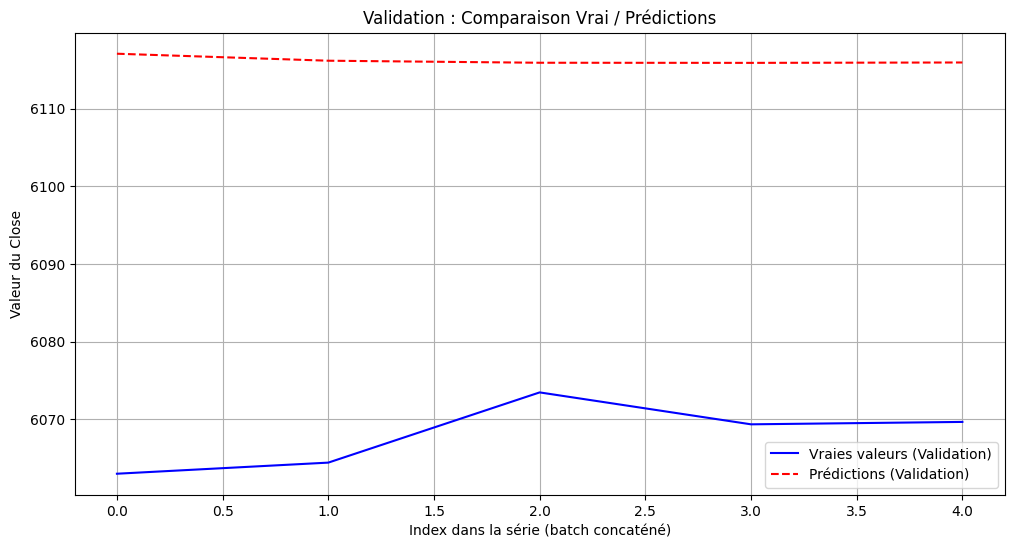

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df_pred['actual'].values, label='Vraies valeurs (Validation)', color='blue')
plt.plot(df_pred['pred'].values, label='Prédictions (Validation)', color='red', linestyle='--')
plt.title('Validation : Comparaison Vrai / Prédictions')
plt.xlabel('Index dans la série (batch concaténé)')
plt.ylabel('Valeur du Close')
plt.legend()
plt.grid(True)
plt.show()